### Data Pre-Processing

In [2]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve, savgol_filter

In [3]:
#Read the dataset
df = pd.read_csv("biosignals_with_demographics_devices_groups.csv",  low_memory=False)

#Print dataset info
print "Shape", df.shape, len(df.PATIENT_CODE.unique())
print df.READING_CATEGORY.unique(), df['READING_CATEGORY'].isnull().any()

Shape (956204, 16) 168
['co2' 'heartbeat' 'bgl' 'bpm' 'weight' 'feeling' 'FEV6' 'FEV1' 'FVC'
 'PEF' 'FEV1_FVC' 'FEF2575' 'perfusionIndex' 'PPG' 'body-temperature' nan
 'activity'] True


In [4]:
#Make DATE in datetime format
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d').dt.date

#Print further info
print df.astype(str).groupby(['READING_CATEGORY', 'VALUE_UNIT', 'DEVICE']).size()

READING_CATEGORY  VALUE_UNIT  DEVICE          
FEF2575           L/s         Spirobank Smart       1304
                              nan                    337
FEV1              L           Spirobank Smart       1304
                              nan                    337
FEV1_FVC          %           Spirobank Smart       1063
                              nan                    337
FEV6              L           Spirobank Smart       1304
                              nan                    337
FVC               L           Spirobank Smart       1304
                              nan                    337
PEF               L/m         Spirobank Smart       1304
                              nan                    337
PPG               nan         Medical Oximeter    157581
                              nan                  22667
activity          nan         X10 Pro              78867
bgl               mg/dL       Contour Next One       146
                              nan        

In [4]:
#FIX MISSING VALUES (NULLS) IN READING_CATEGORY based on the VALUE_UNIT
df['READING_CATEGORY'] = np.where((df['READING_CATEGORY'].isnull()) & (df['VALUE_UNIT'] == 'bpm'), 'heartbeat', df['READING_CATEGORY'])
df['READING_CATEGORY'] = np.where((df['READING_CATEGORY'].isnull()) & (df['VALUE_UNIT'] == 'mm Hg'), 'bpm', df['READING_CATEGORY'])
df['READING_CATEGORY'] = np.where((df['READING_CATEGORY'].isnull()) & (pd.notna(df['PPG_ARRAY'])), 'PPG', df['READING_CATEGORY'])
df['READING_CATEGORY'] = np.where((df['READING_CATEGORY'].isnull()) & (df['VALUE_UNIT'] == '%') & (df['DEVICE'] == 'Medical Oximeter'), 'co2', df['READING_CATEGORY'])
df['READING_CATEGORY'] = np.where((df['READING_CATEGORY'].isnull()) & (df['VALUE_UNIT'] == '%') & (df['DEVICE'] == 'Spirobank Smart'), 'FEV1_FVC', df['READING_CATEGORY'])
df['READING_CATEGORY'] = np.where((df['READING_CATEGORY'].isnull()) & (df['VALUE_UNIT'].isnull()) & (df['DEVICE'] == 'Medical Oximeter'), 'perfusionIndex', df['READING_CATEGORY'])
df['READING_CATEGORY'] = np.where((df['READING_CATEGORY'].isnull()) & (df['VALUE_UNIT'].isnull()) & (df['DEVICE'].isnull()), 'feeling', df['READING_CATEGORY'])

#Replace NULLS in CATEGORY, GENDER and YEAR_OF_BIRTH with the value unknown
df['CATEGORY'] = np.where((df['CATEGORY'].isnull()), 'unknown', df['CATEGORY'])
df['GENDER'] = np.where((df['GENDER'].isnull()), 'unknown', df['GENDER'])
df['YEAR_OF_BIRTH'] = np.where((df['YEAR_OF_BIRTH'].isnull()), 'unknown', df['YEAR_OF_BIRTH'])

#Replace the YEAR_OF_BIRTH with AGE
df['AGE'] = np.where((pd.notna(df['YEAR_OF_BIRTH'])), (2018 - df['YEAR_OF_BIRTH'].astype(int)), df['YEAR_OF_BIRTH'])

#Move PPG_ARRAY values to READING_VALUE
df.loc[df['PPG_ARRAY'].notna(),'READING_VALUE'] = df['PPG_ARRAY']

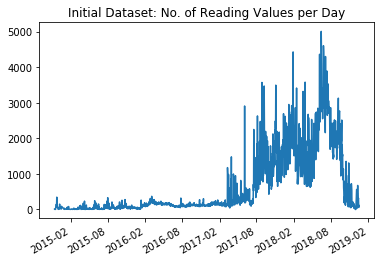

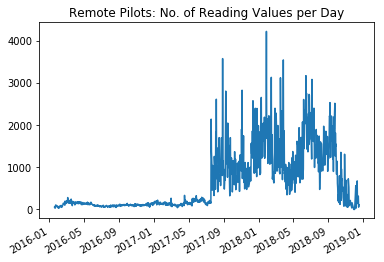

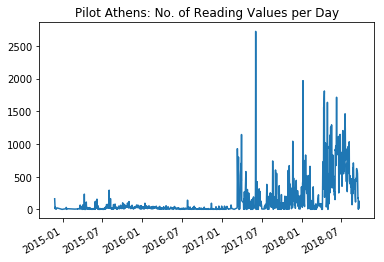

In [5]:
#Plot number of total readings per day (956204 records)
df[['DATE', 'AGE']].groupby(['DATE']).count()
plt.plot(df[['DATE', 'AGE']].groupby(['DATE']).count())
plt.gcf().autofmt_xdate()
plt.title('Initial Dataset: No. of Reading Values per Day')
plt.savefig('patients/preprocess/All_ValuesPerDay.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()

'''
#Plot number of total readings per day (956204 values)
df[['DATE', 'AGE']].groupby(['DATE']).count()
plt.plot(df[['DATE', 'AGE']].groupby(['DATE']).count(),'o')
plt.gcf().autofmt_xdate()
plt.title('No. of Reading Values per Day')
plt.savefig('patients/preprocess/All_ValuesPerDay_2.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()
'''
#Split dataset in pilots and BioAssist Friends
df3 = df[~df['CATEGORY'].isin(['unknown', 'BioAssist Friends', 'BioAssist tester', 'Doctor Call', 'b-open tester', 'Demo Users', 'ΕΠΙΨΥ', pd.np.nan])]
df4 = df[df['CATEGORY'].isin(['BioAssist Friends'])]

#Plot number of total READING_VALUE per day only for pilots (672221 records)
df3[['DATE', 'AGE']].groupby(['DATE']).count()
plt.plot(df3[['DATE', 'AGE']].groupby(['DATE']).count())
plt.gcf().autofmt_xdate()
plt.title('Remote Pilots: No. of Reading Values per Day')
plt.savefig('patients/preprocess/Pilots_ValuesPerDay.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()

#Plot number of total READING_VALUE per day only for BioAssist Friends (167850 records)
df4[['DATE', 'AGE']].groupby(['DATE']).count()
plt.plot(df4[['DATE', 'AGE']].groupby(['DATE']).count())
plt.gcf().autofmt_xdate()
plt.title('Pilot Athens: No. of Reading Values per Day')
plt.savefig('patients/preprocess/BioassistFriends_ValuesPerDay.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()

In [6]:
#Print some info
print 'The', len(df3['PATIENT_CODE'].unique()) ,'pilot patients out of the total', len(df['PATIENT_CODE'].unique()), 'patients consist the', round(len(df3.index)*100/len(df.index), 2),'% of the total readings'
print 'The', len(df4['PATIENT_CODE'].unique()) ,'bioassist friends out of the total', len(df['PATIENT_CODE'].unique()), 'patients consist the', round(len(df4.index)*100/len(df.index), 2),'% of the total readings'

The 49 pilot patients out of the total 168 patients consist the 70.0 % of the total readings
The 36 bioassist friends out of the total 168 patients consist the 17.0 % of the total readings


In [7]:
#Move diastolic bpm from READING_VALUE2 to READING_VALUE and rename to bpm_dias
df2 = df[(df['READING_VALUE2'] != 0) & (df['READING_VALUE2'].notna())]
df2 = df2.replace('bpm', 'bpm_dia')
df2['READING_VALUE'] = df2['READING_VALUE2']
df = df.append(df2)

#Remove columns and sort by patient code and DATETIME
df = df.sort_values(by=['PATIENT_CODE', 'DATE', 'TIME']).drop(columns=['ID', 'MASTER_ID', 'PPG_ARRAY', 'READING_VALUE2', 'DEVICE', 'VALUE2_UNIT', 'ZIP_CODE', 'YEAR_OF_BIRTH', 'VALUE_UNIT'])

#Split READING_VALUE into separate columns for each READING_CATEGORY and group them for the same CREATE_DATETIME
df = df.pivot_table(index=['PATIENT_CODE', 'CATEGORY', 'GENDER', 'AGE', 'DATE', 'TIME'], columns='READING_CATEGORY', values='READING_VALUE', aggfunc='first')
df.reset_index(inplace=True)

#Rename
df.rename(columns={'bpm': 'bpm_sys', 'co2': 'SpO2'}, inplace=True)
df['CATEGORY'] = np.where(df['CATEGORY'] == 'BioAssist Friends', 'Pilot Athens', df['CATEGORY'])
df['CATEGORY'] = np.where(df['CATEGORY'] == 'Πιλότος Λάρισας', 'Pilot Larisa', df['CATEGORY'])
df['CATEGORY'] = np.where(df['CATEGORY'] == 'Ανενεργοί - Πιλότος Λάρισας', 'Pilot Larisa - Inactive', df['CATEGORY'])
df['CATEGORY'] = np.where(df['CATEGORY'] == 'Πνευμονική εμβολή', 'Pilot2 Larisa', df['CATEGORY'])
df['CATEGORY'] = np.where(df['CATEGORY'] == 'Ανενεργοί - Πνευμονική εμβολή', 'Pilot2 Larisa - Inactive', df['CATEGORY'])
df['CATEGORY'] = np.where(df['CATEGORY'] == 'Πιλότος Κρήτη', 'Pilot Crete', df['CATEGORY'])
df['CATEGORY'] = np.where(df['CATEGORY'] == 'Ανενεργοί - Πιλότος Κρήτης', 'Pilot Crete - Inactive', df['CATEGORY'])
df['CATEGORY'] = np.where(df['CATEGORY'] == 'Πιλότος Θεσσαλονίκης', 'Pilot Thessaloniki', df['CATEGORY'])
df['CATEGORY'] = np.where(df['CATEGORY'] == 'Ανενεργοί - Πιλότος Θεσσαλονίκης', 'Pilot Thessaloniki - Inactive', df['CATEGORY'])


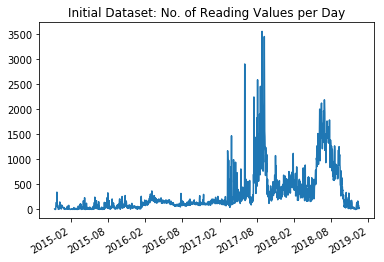

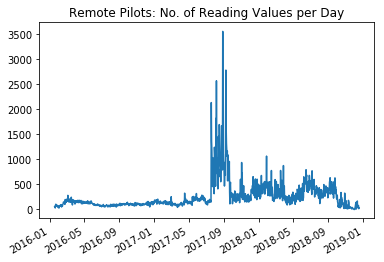

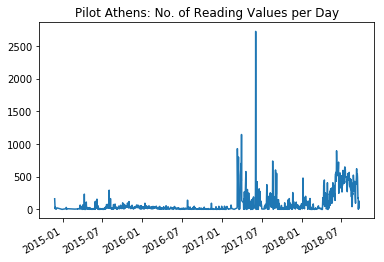

In [8]:
#Plot number of total readings per day for grouped READING_VALUE (466242 rows with values)
df[['DATE', 'AGE']].groupby(['DATE']).count()
plt.plot(df[['DATE', 'AGE']].groupby(['DATE']).count())
plt.gcf().autofmt_xdate()
plt.title('Initial Dataset: No. of Reading Values per Day')
plt.savefig('patients/preprocess/All_GroupedValuesPerDay.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()

#Split dataset in pilots and BioAssist Friends for grouped READING_VALUE
df3 = df[~df['CATEGORY'].isin(['unknown', 'Pilot Athens', 'BioAssist tester', 'Doctor Call', 'b-open tester', 'Demo Users', 'ΕΠΙΨΥ', pd.np.nan])]
df4 = df[df['CATEGORY'].isin(['Pilot Athens'])]

#Print and plot number of total readings per day only for pilots for grouped READING_VALUE (273959 rows with values)
df3[['DATE', 'AGE']].groupby(['DATE']).count()
plt.plot(df3[['DATE', 'AGE']].groupby(['DATE']).count())
plt.gcf().autofmt_xdate()
plt.title('Remote Pilots: No. of Reading Values per Day')
plt.savefig('patients/preprocess/RemotePilots_GroupedValuesPerDay.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()

#Print and plot number of total readings per day only for BioAssist Friends for grouped READING_VALUE (100635 rows with values)
df4[['DATE', 'AGE']].groupby(['DATE']).count() 
plt.plot(df4[['DATE', 'AGE']].groupby(['DATE']).count())
plt.gcf().autofmt_xdate()
plt.title('Pilot Athens: No. of Reading Values per Day')
plt.savefig('patients/preprocess/PilotAthens_GroupedValuesPerDay.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()

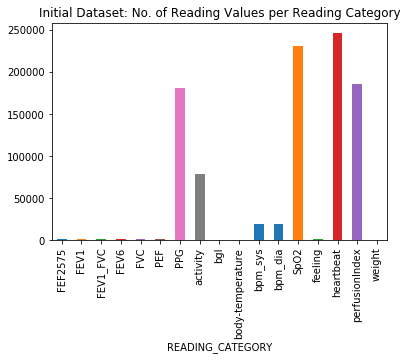

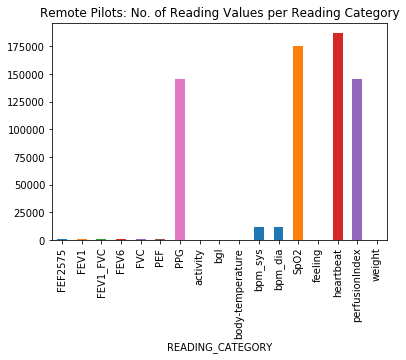

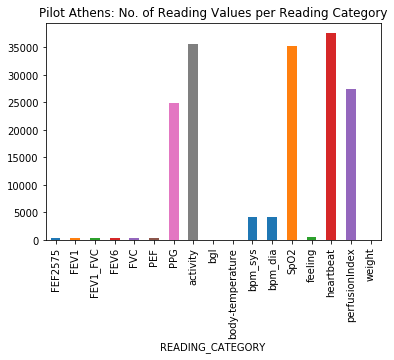

In [9]:
#Plot number of total readings for grouped READING_VALUE
df.drop(columns=['PATIENT_CODE', 'TIME','CATEGORY', 'GENDER', 'AGE', 'DATE']).count()
fig1 = df.drop(columns=['PATIENT_CODE','CATEGORY', 'GENDER', 'AGE', 'DATE', 'TIME']).count().plot(kind='bar', fontsize=10)
fig1 = fig1.get_figure()
plt.title('Initial Dataset: No. of Reading Values per Reading Category')
plt.savefig('patients/preprocess/All_ValuesPerCategory.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()

#Plot number of total readings only for pilots for grouped READING_VALUE
df3.drop(columns=['PATIENT_CODE', 'TIME','CATEGORY', 'GENDER', 'AGE', 'DATE']).count()
fig2 = df3.drop(columns=['PATIENT_CODE', 'TIME','CATEGORY', 'GENDER', 'AGE', 'DATE']).count().plot(legend=False, kind='bar', fontsize=10)
fig2 = fig2.get_figure()
plt.title('Remote Pilots: No. of Reading Values per Reading Category')
plt.savefig('patients/preprocess/RemotePilots_ValuesPerCategory.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()

#Plot number of total readings only for BioAssist Friends for grouped READING_VALUE
df4.drop(columns=['PATIENT_CODE', 'TIME','CATEGORY', 'GENDER', 'AGE', 'DATE']).count()
fig3 = df4.drop(columns=['PATIENT_CODE', 'TIME','CATEGORY', 'GENDER', 'AGE', 'DATE']).count().plot(legend=False, kind='bar', fontsize=10)
fig3 = fig3.get_figure()
plt.title('Pilot Athens: No. of Reading Values per Reading Category')
plt.savefig('patients/preprocess/PilotAthens_ValuesPerCategory.svg', format='svg', dpi=600, bbox_inches = "tight")
plt.show()

In [10]:
#Remove READING_CATEGORY with too little number of values
df = df.drop(columns=['feeling', 'body-temperature', 'bgl', 'activity', 'weight'])

#Remove rows with all values NaN
df = df.dropna(thresh=7)

#Sort the dataframe according to PATIENT_CODE then DATE and then ΤΙΜΕ
df = df.sort_values(by=['PATIENT_CODE', 'DATE', 'TIME'])

#Truncate miliseconds ftom TIME
df['TIME'] = ((df['TIME'] - 500)/1000).round()

#Keep only the pilots and the bioassist friends
df = df[~df['CATEGORY'].isin(['unknown', 'BioAssist tester', 'Doctor Call', 'b-open tester', 'Demo Users', 'ΕΠΙΨΥ', pd.np.nan])]

#print the Categories
print df.CATEGORY.unique()
print len(df.CATEGORY.unique())

['Pilot Larisa' 'Pilot Crete' 'Pilot Athens' 'Pilot Thessaloniki'
 'Pilot Larisa - Inactive' 'Pilot2 Larisa' 'Pilot2 Larisa - Inactive'
 'Pilot Thessaloniki - Inactive' 'Pilot Crete - Inactive']
9


In [11]:
#Append consecutive PPG readings,  smooth them, and produce their skew, kurt, and period
df["PPG_united"] = np.nan
df["PPG_skew"] = np.nan
df["PPG_kurt"] = np.nan
df["PPG_period"] = np.nan
df["PPG_united"] = df["PPG_united"].astype('object')
for i in range(0, len(df['PATIENT_CODE'].unique())):
    dftmp = df[df.PATIENT_CODE == df.PATIENT_CODE.unique()[i]]
    lst = []
    for j in range(0, len(dftmp['DATE'].unique())):
        dftmp2 = dftmp[dftmp.DATE == dftmp.DATE.unique()[j]]
        flag = 0
        time = 100
        l=0
        for k in range(0, len(dftmp2['PPG'])):
            if (type(dftmp2['PPG'].iloc[k]) == str):
                if flag == 1:
                    if (((dftmp2['TIME'].iloc[k] - time) <= 2) | ((dftmp2['TIME'].iloc[k] - time) == 42) | ((dftmp2['TIME'].iloc[k] - time) == 4042)):
                        lst.extend(list(map(int, dftmp2['PPG'].iloc[k].replace("[","").replace("]","").replace(",","").split())))
                    else:
                        dftmp2.at[dftmp2.index[l],'PPG_united'] = lst
                        lst2 = savgol_filter(lst, 49, 3)
                        corr = fftconvolve(lst2, lst2[::-1], mode='full')
                        corr = corr[len(corr)//2:]
                        #Find the first low point
                        d = np.diff(corr)
                        start = np.nonzero(np.ravel(d > 0))
                        if len(start[0]) != 0:
                            start = start[0][0]
                            #Find the next peak after the low point (other than 0 lag)
                            period = np.argmax(corr[start:]) + start
                            dftmp2.loc[dftmp2.index[l],'PPG_kurt'] = pd.DataFrame(dftmp2.at[dftmp2.index[l],'PPG_united']).kurt()[0]
                            dftmp2.loc[dftmp2.index[l],'PPG_skew'] = pd.DataFrame(dftmp2.at[dftmp2.index[l],'PPG_united']).skew()[0]
                            dftmp2.loc[dftmp2.index[l],'PPG_period'] = period
                        lst = list(map(int, dftmp2['PPG'].iloc[k].replace("[","").replace("]","").replace(",","").split()))
                else:
                    lst = list(map(int, dftmp2['PPG'].iloc[k].replace("[","").replace("]","").replace(",","").split()))
                    flag = 1
                time = dftmp2['TIME'].iloc[k]
                l=k
        if len(lst) != 0:
            dftmp2.at[dftmp2.index[l],'PPG_united'] = lst
            lst2 = savgol_filter(lst, 49, 3)
            corr = fftconvolve(lst2, lst2[::-1], mode='full')
            corr = corr[len(corr)//2:]
            #Find the first low point
            d = np.diff(corr)
            start = np.nonzero(np.ravel(d > 0))
            if len(start[0]) != 0:
                start = start[0][0]
                #Find the next peak after the low point (other than 0 lag)
                period = np.argmax(corr[start:]) + start
                dftmp2.loc[dftmp2.index[l],'PPG_kurt'] = pd.DataFrame(dftmp2.at[dftmp2.index[l],'PPG_united']).kurt()[0]
                dftmp2.loc[dftmp2.index[l],'PPG_skew'] = pd.DataFrame(dftmp2.at[dftmp2.index[l],'PPG_united']).skew()[0]
                dftmp2.loc[dftmp2.index[l],'PPG_period'] = period
        dftmp.loc[dftmp.DATE == dftmp.DATE.unique()[j], 'PPG_united'] = dftmp2['PPG_united'].values
        dftmp.loc[dftmp.DATE == dftmp.DATE.unique()[j], 'PPG_kurt'] = dftmp2['PPG_kurt'].values
        dftmp.loc[dftmp.DATE == dftmp.DATE.unique()[j], 'PPG_skew'] = dftmp2['PPG_skew'].values
        dftmp.loc[dftmp.DATE == dftmp.DATE.unique()[j], 'PPG_period'] = dftmp2['PPG_period'].values
    df.loc[df.PATIENT_CODE == df.PATIENT_CODE.unique()[i], 'PPG_united'] = dftmp['PPG_united'].values
    df.loc[df.PATIENT_CODE == df.PATIENT_CODE.unique()[i], 'PPG_kurt'] = dftmp['PPG_kurt'].values
    df.loc[df.PATIENT_CODE == df.PATIENT_CODE.unique()[i], 'PPG_skew'] = dftmp['PPG_skew'].values
    df.loc[df.PATIENT_CODE == df.PATIENT_CODE.unique()[i], 'PPG_period'] = dftmp['PPG_period'].values
    print i

#Save preprocess to .csv
df.to_csv("patients/patients.csv")

c:\python27\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


In [12]:
print "Shape", df.shape, len(df.CATEGORY.unique())

Shape (338729, 22) 9


In [13]:
print len(df.PATIENT_CODE.unique())

83
